<a href="https://colab.research.google.com/github/Jsakkos/mf-lon-cyanos-rvae/blob/main/notebooks/example_segmentation_cellpose_organelles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mask for the individual organelles and the set of organelles are created in this notebook.

First, the original images are segmented with Cellpose (https://www.cellpose.org/) .

Second, from the masks created with Cellpose, masks for the individual organelles and the set of organelles are extracted.

Only one set of images is segmented on this notebook. This is the induced set of images taken at 24 hours. 

Authors:

Jonathan Sakkos, Michigan State University

Miguel Fuentes-Cabrera, Center for Nanophase Materials Sciences, Oak Ridge National Laboratory

In [ ]:
# Import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
import gdown
from skimage.measure import label, regionprops, regionprops_table

In [ ]:
#Download the tar.gz file with the images
!gdown "https://drive.google.com/uc?id=1uqPd8f4Rn9-UP6TEMzLvsNI3YWZiG9OL"

Downloading...
From: https://drive.google.com/uc?id=1uqPd8f4Rn9-UP6TEMzLvsNI3YWZiG9OL
To: /content/example-24-induced.tar.gz
100% 13.7M/13.7M [00:00<00:00, 64.2MB/s]


In [ ]:
!gunzip /content/example-24-induced.tar.gz

gzip: /content/example-24-induced.tar already exists; do you wish to overwrite (y or n)? y


In [ ]:
!tar -xvf /content/example-24-induced.tar

tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
./._example-24-induced
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
example-24-induced/
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
example-24-induced/._.DS_Store
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
example-24-induced/.DS_Store
tar: Ignoring unknown extended header

In [ ]:
!ls

example-24-induced  example-24-induced.tar  sample_data


In [ ]:
cd /content/example-24-induced/

/content/example-24-induced


In [ ]:
!ls

'30 uM Theophylline-02.czi'


In [ ]:
pip install cellpose==0.6.2

In [ ]:
from cellpose import models, utils,plot,io

In [ ]:
use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

>>> GPU activated? 1


In [ ]:
pip install czifile

In [ ]:
import czifile

**For some reason, the directory czi-controls contains files that start with "._". These files must be deleted for the cell below to work.**

In [ ]:
!rm ._*

In [ ]:
folder = '/content/example-24-induced'

images = [os.path.join(root, filename)
          for root, dirs, files in os.walk(folder)
          for filename in files
          if filename.lower().endswith('.czi')]

# import czifile
# image = czifile.imread("Control-02.czi")
# brightfield = image[0,2,:,:,0]
# dsred = image[0,1,:,:,0]
# gfp = image[0,0,:,:,0]

total_gfp = []
total_dsred = []

for file in images:
    image = czifile.imread(file)
    gfp = image[0,0,:,:,0]
    dsred = image[0,1,:,:,0]
    total_gfp.append(gfp) 
    total_dsred.append(dsred)

In [ ]:
images

['/content/example-24-induced/30 uM Theophylline-02.czi']

In [ ]:
len(total_gfp), len(total_dsred)

(1, 1)

In [ ]:
#We use a diameter of 7 for the organelles and 20 for the cells

#Segmented the images to obtain masks of set of  organelles
masks_d, flows_d, styles, diams = model.eval(total_dsred, diameter = 20)

#Segmented the images to obtain masks of individual organelles
masks_g, flows_g, styles, diams = model.eval(total_gfp, diameter = 7)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


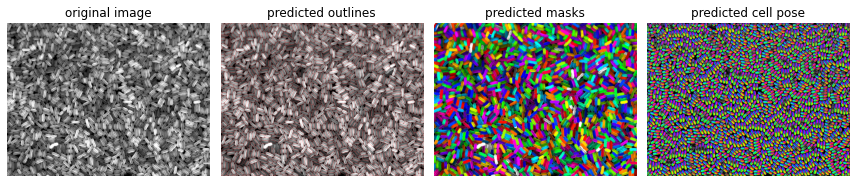

In [ ]:
#Visualizing the Cellpose segmentation for the cells channel 
nimg = len(total_dsred)
for idx in range(nimg):
    maski = masks_d[idx]
    flowi = flows_d[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, total_dsred[idx], maski, flowi)
    plt.tight_layout()
    plt.show()

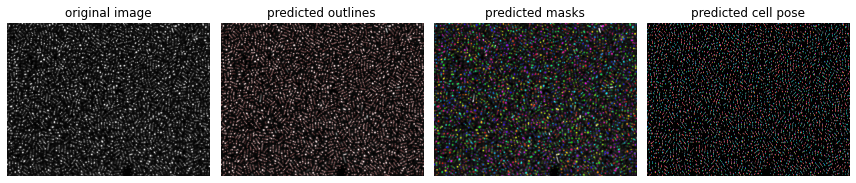

In [ ]:
#Visualizing the Cellpose segmentation for the carboxysomes channel
nimg = len(total_gfp)
for idx in range(nimg):
    maski = masks_g[idx]
    flowi = flows_g[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, total_gfp[idx], maski, flowi)
    plt.tight_layout()
    plt.show()

In [ ]:
# Some helper functions to cut windows of the same size and containing only invididual organelles.
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
  
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = target_channel * sample.filled_image
    if rotate == True:
      rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
      H, W = rotated_image.shape
      image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
      return make_square(normalize_01(image_center),box_size)
    else:
      return make_square(normalize_01(target_channel),box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=40,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

Cutting the mask for individual organelles

In [ ]:
array_gfp_masks = np.asarray(masks_g)
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

example_mask_organelles = np.vstack(carboxysome_stack[i] for i in range(n))
print(example_mask_organelles.shape)

(1, 1460, 1936)
(4551, 40, 40)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


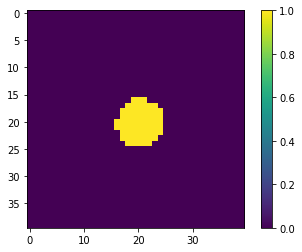

In [ ]:
plt.imshow(example_mask_organelles[3000,:,:])
plt.colorbar()

In [ ]:
# Some helper functions
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
  
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = (target_channel > 0) * sample.filled_image
    if rotate == True:
      rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
      H, W = rotated_image.shape
      image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
      return make_square(np.ones(sample.filled_image.shape)*(image_center),box_size)
    else:
      return make_square(np.ones(sample.filled_image.shape)*(target_channel),box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=115,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask.any:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

Cutting the mask for the set of organelles

In [ ]:
array_dsred_masks = np.asarray(masks_d)


n = len(array_dsred_masks[:,0,0])
# print(n)
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],array_dsred_masks[i],rotate=False))
example_mask_set = np.vstack(carboxysome_stack[i] for i in range(n))
print(example_mask_set.shape)

(1191, 115, 115)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


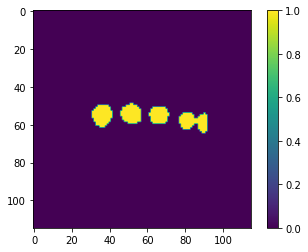

In [ ]:
plt.imshow(example_mask_set[1100,:,:])
plt.colorbar()